In [1]:
# import modules
import seaborn
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from abc import abstractmethod
from sklearn.datasets import load_digits
from sklearn.model_selection import KFold

# Base Classes

In [2]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''


class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 

    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction

    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D)) # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features  = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)

    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                         indices to be considered for the present split
                         
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        node.left = left
        node.right = right
        node.threshold = t_min
        node.split_index = j_min

        # return the children (to be placed on the stack)
        return left, right

    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        return np.random.default_rng().choice(D, D_try, replace=False)

    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        feature_values = node.features[:, j]
        return (feature_values[1:] + feature_values[:-1]) / 2

    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()

        left_children = node.features[:, j] <= t
        left.features = node.features[left_children]
        left.responses = node.responses[left_children]

        right.features = node.features[~left_children]
        right.responses = node.responses[~left_children]

        return left, right

    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")

    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


# Regression Tree
To make the differentiation between a ClassificationTree and RegressionTree meaningful, we decided to use the mean of all responses as prediction for leaf nodes.

<div style="color: green">
Unlike the sample solution, we additionally check for `n_min` inside the loss computation and return the maximum loss if the split would be to small.
While this isn't stricly required with proper handling in the actual splitting, it makes our implementation less error-prone and thus more resilient.
</div>

In [3]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)

    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_children = node.features[:, j] <= t

        left_responses = node.responses[left_children]
        right_responses = node.responses[~left_children]

        if len(left_responses) < self.n_min or len(right_responses) < self.n_min:
            return float("inf")

        left_prediction = np.mean(left_responses)
        right_prediction = np.mean(right_responses)

        return np.sum((left_responses - left_prediction) ** 2) + np.sum((right_responses - right_prediction) ** 2)

    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        node.prediction = np.mean(node.responses)


# Classification Tree
We decided to use Gini Impurity as loss method, since it already perfectly supports multi-class trees out of the box.

<div style="color: green">
Since we used the Gini Impurity, our implementation can not be compared to the sample solution that easily.
But since the parts that don't involve calculating the Gini Impurity itself are exactly identical to the RegressionTree implementation, we assume it would be very close to what a sample solution for Gini Impurity would look like.
</div>

In [4]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''

    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes

    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_children = node.features[:, j] <= t

        left_responses = node.responses[left_children]
        right_responses = node.responses[~left_children]

        if len(left_responses) < self.n_min or len(right_responses) < self.n_min:
            return float("inf")
        
        _, left_label_counts = np.unique(left_responses, return_counts=True)
        _, right_label_counts = np.unique(right_responses, return_counts=True)
        
        left_impurity = 1 - np.sum((left_label_counts / len(left_responses)) ** 2)
        right_impurity = 1 - np.sum((right_label_counts / len(right_responses)) ** 2)

        return left_impurity * len(left_responses) + right_impurity * len(right_responses)

    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        node.prediction = scipy.stats.mode(node.responses, axis=None, keepdims=False)[0]


# Evaluation of Regression and Classification Tree

In [5]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


<div style="color: green">
We forgot to assign quantized labels in the cross-validation of our evaluation, which makes the results incomparable to the sample solution (Since we can't generate an accuracy score without assigning definitive labels first).
Aside from that, the cross-validation itself is nothing spectacular and basically identical to the sample solution.
</div>

In [6]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results

splitter = KFold(n_splits=10)
n_mins = [1, 2, 5, 10, 20, 50]
classes = list(np.unique(labels))

for n_min in n_mins:
    tree = RegressionTree(n_min=n_min)

    for train_index, test_index in splitter.split(features):
        tree.train(features[train_index], labels[train_index])
        deviations = np.zeros((len(classes), 2))

        for sample in test_index:
            label = labels[sample]
            prediction = tree.predict(features[sample])
            deviations[classes.index(label)] += [prediction, 1]

    print("Average scores for classes", classes, "with n_min =", n_min, "\n", deviations[:, 0] / deviations[:, 1])

Average scores for classes [3, 9] with n_min = 1 
 [4.66666667 8.66666667]
Average scores for classes [3, 9] with n_min = 2 
 [4.16666667 7.5       ]
Average scores for classes [3, 9] with n_min = 5 
 [3.61904762 8.26666667]
Average scores for classes [3, 9] with n_min = 10 
 [4.40064103 8.16452991]
Average scores for classes [3, 9] with n_min = 20 
 [5.03726708 7.18576074]
Average scores for classes [3, 9] with n_min = 50 
 [4.48722042 8.13574661]


<div style="color: green">
Our accuracy of 85% matches up with the test error rate of 18%, especially considering the relatively high variance.
As before, cross-validation is a very straightforward task, so our implementation is essentially equal except for cosmetic differences.
</div>

In [7]:
# perform 5-fold cross-validation with labels 3 and 9
# using ClassificationTree(classes=np.unique(labels))
# and comment on your results

splitter = KFold(n_splits=10)
n_mins = [1, 2, 5, 10, 20, 50]
classes = list(np.unique(labels))

for n_min in n_mins:
    tree = ClassificationTree(classes=classes, n_min=n_min)
    confusion_matrix = np.zeros((len(classes), len(classes)))

    for train_index, test_index in splitter.split(features):
        tree.train(features[train_index], labels[train_index])

        for sample in test_index:
            label = labels[sample]
            prediction = tree.predict(features[sample])
            confusion_matrix[classes.index(label)][classes.index(prediction)] += 1

    print("Confusion matrix for classes", classes, "with n_min =", n_min, "\n", confusion_matrix)
    print("Accuracy: {:.1%}".format(np.trace(confusion_matrix) / np.sum(confusion_matrix)))

Confusion matrix for classes [3, 9] with n_min = 1 
 [[156.  27.]
 [ 28. 152.]]
Accuracy: 84.8%
Confusion matrix for classes [3, 9] with n_min = 2 
 [[171.  12.]
 [ 29. 151.]]
Accuracy: 88.7%
Confusion matrix for classes [3, 9] with n_min = 5 
 [[161.  22.]
 [ 30. 150.]]
Accuracy: 85.7%
Confusion matrix for classes [3, 9] with n_min = 10 
 [[145.  38.]
 [ 22. 158.]]
Accuracy: 83.5%
Confusion matrix for classes [3, 9] with n_min = 20 
 [[148.  35.]
 [ 20. 160.]]
Accuracy: 84.8%
Confusion matrix for classes [3, 9] with n_min = 50 
 [[162.  21.]
 [ 33. 147.]]
Accuracy: 85.1%


Because our training step took us less than one second per training set, and the variance between different runs caused by the random feature selection was too high to get meaningful results out of the cross-validation, we increased the number of splits to 10 and calculated the confusion matrices for different `n_min` values, all the way from 1 to 50.

Surprisingly, the impact of reducing `n_min` further below a threshold of approximately 10-20 does not seem to have any significant impact on the prediction quality, while still increasing the training duration (Due to the higher depth of the resulting tree). Overall, a single ClassificationTree was only able to reach an accuracy of 85-90%.

## Proof of Concept: Multi-Class Classification
Our current implementations of RegressionTree and ClassificationTree support multiple classes:

RegressionTree can handle any score (Not just -1 and 1), as already shown in the cross-valdation.
To demonstrate the multi-class functionality of ClassificationTree, we will run a simple test case with three instead of two labels.

Technically speaking, we even ignore the supplies `classes` parameter, and only carry it for compatibility purposes.
The actually returned label in ClassificationTree is generated directly from the `reponses` supplied during training, which is why the number of labels don't matter to our implementation.

In [8]:
instances = (digits.target == 3) | (digits.target == 7) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

splitter = KFold(n_splits=10)
classes = list(np.unique(labels))

tree = ClassificationTree(classes=classes)
confusion_matrix = np.zeros((len(classes), len(classes)))

for train_index, test_index in splitter.split(features):
    tree.train(features[train_index], labels[train_index])

    for sample in test_index:
        label = labels[sample]
        prediction = tree.predict(features[sample])
        confusion_matrix[classes.index(label)][classes.index(prediction)] += 1

print("Confusion matrix for classes", classes, "\n", confusion_matrix)
print("Accuracy: {:.1%}".format(np.trace(confusion_matrix) / np.sum(confusion_matrix)))

Confusion matrix for classes [3, 7, 9] 
 [[144.   8.  31.]
 [  6. 153.  20.]
 [ 20.  14. 146.]]
Accuracy: 81.7%


# Regression and Classification Forest
Similar to the method chosen for leaf predicitions, we decided to use the mode for the ClassificationForest.
We decided to remove the forest size argument from the RegressionTree construction and infer it based on the training data instead.

In [9]:
def bootstrap_sampling(features, responses, split_by_response=None):
    '''return a bootstrap sample of features and responses
    '''

    if split_by_response is None:
        # determine the number of data points
        num_data_points = len(features)

        # generate a set of random indices with replacement
        bootstrap_indices = np.random.choice(range(num_data_points), size=num_data_points, replace=True)

        # use these indices to create a bootstrap sample of the original dataset
        bootstrap_features = features[bootstrap_indices]
        bootstrap_responses = responses[bootstrap_indices]
    else:
        # split the data set based on the supplied response
        features_target = features[responses == split_by_response]
        responses_target = responses[responses == split_by_response]

        features_off_target = features[responses != split_by_response]
        responses_off_target = responses[responses != split_by_response]

        # determine the number of data points
        num_target_points = len(features_target)
        num_off_target_points = len(features_off_target)
        
        # generate a set of random indices with replacement
        bootstrap_indices_target = np.random.choice(range(num_target_points), size=num_target_points, replace=True)
        bootstrap_indices_off_target = np.random.choice(range(num_off_target_points), size=num_target_points, replace=True)
        
        # use these indices to create a bootstrap sample of the original dataset
        bootstrap_features = np.concatenate((features_target[bootstrap_indices_target], features_off_target[bootstrap_indices_off_target]))
        bootstrap_responses = np.concatenate((responses_target[bootstrap_indices_target], responses_off_target[bootstrap_indices_off_target]))
        bootstrap_responses = np.array([1 if r == split_by_response else -1 for r in bootstrap_responses])

    return bootstrap_features, bootstrap_responses

In [10]:
class RegressionForest():
    def __init__(self, n_min=10):
        self.n_min = n_min
    
    def train(self, features, responses):
        self.classes = list(np.unique(responses))
        self.trees = [RegressionTree(self.n_min) for c in self.classes]

        for index, tree in enumerate(self.trees):
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses, self.classes[index])
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        predictions = [tree.predict(x) for tree in self.trees]

        index_max = -1
        score_max = -1
        for index, score in enumerate(predictions):
            if score > score_max:
                index_max = index
                score_max = score

        if score_max > 0:
            return self.classes[index_max]
        else:
            return "unknown"

In [11]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=10):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        predictions = [tree.predict(x) for tree in self.trees]
        return scipy.stats.mode(predictions, axis=None, keepdims=False)[0]

<div style="color: green">
1. The above code's predict method in the RegressionForest class tries to find the tree with the highest prediction. This is not consistent with the idea of regression forests, where the final prediction is typically the average of the predictions from all trees. <br>
2. In the above code's RegressionForest class, the number of trees seems to be equal to the number of unique responses in the training data. However, the number of trees in the forest should be independent of the number of unique responses. 
</div>

# Evaluation of Regression and Decision Forest

In [12]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionForest(n_trees=10)
# and comment on your results
instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

splitter = KFold(n_splits=5)
classes = list(np.unique(labels))
classes.append("unknown")

forest = RegressionForest()

confusion_matrix = np.zeros((len(classes), len(classes)))

for train_index, test_index in splitter.split(features):
    forest.train(features[train_index], labels[train_index])

    for sample in test_index:
        label = labels[sample]
        prediction = forest.predict(features[sample])
        confusion_matrix[classes.index(label)][classes.index(prediction)] += 1

print("Confusion matrix for classes", classes, "\n", confusion_matrix)
print("Accuracy: {:.1%}".format(np.trace(confusion_matrix) / np.sum(confusion_matrix)))

Confusion matrix for classes [3, 9, 'unknown'] 
 [[146.  18.  19.]
 [ 14. 155.  11.]
 [  0.   0.   0.]]
Accuracy: 82.9%


In [13]:
# perform 5-fold cross-validation with labels 3 and 9
# using DecisionForest(n_trees=10, classes=np.unique(labels))
# and comment on your results
instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

splitter = KFold(n_splits=5)
classes = list(np.unique(labels))

forest = ClassificationForest(n_trees=10, classes=classes)
confusion_matrix = np.zeros((len(classes), len(classes)))

for train_index, test_index in splitter.split(features):
    forest.train(features[train_index], labels[train_index])

    for sample in test_index:
        label = labels[sample]
        prediction = forest.predict(features[sample])
        confusion_matrix[classes.index(label)][classes.index(prediction)] += 1

print("Confusion matrix for classes", classes, "\n", confusion_matrix)
print("Accuracy: {:.1%}".format(np.trace(confusion_matrix) / np.sum(confusion_matrix)))

Confusion matrix for classes [3, 9] 
 [[171.  12.]
 [ 15. 165.]]
Accuracy: 92.6%


As seen in the direct comparison, the accuracy of the ClassificationForest is significantly higher than the accuracy of the RegressionForest.
The main difference between our two implementations is the predicted label of a leaf, which uses the mode (Which would be equivalent to the median for regression) in ClassificationTree, but the mean in RegressionTree.
This makes ClassificationTree more robust against outliers, while RegressionTree also takes outliers into consideration.

On the other hand, ClassificationTree runs at a higher risk of being overfitted for small `n_min` because of this, while RegressionTree should be more resistent to overfitting.

<div style="color: green">
1.Overfitting Discussion: The above code's discussion on the difference between ClassificationForest and RegressionForest regarding overfitting is excellent and shows a deep understanding of the subject.<br>
2.Evaluation: The above code  has utilized confusion matrix and accuracy for model evaluation which is appropriate for this task. <br>
3.The above code  hasn't explicitly shown how to ensure the diversity of trees in the forest by using bootstrap samples, which is an important aspect of the assignment. Make sure to clarify this in your code or comments.<br>
4.In the above code 's implementation of K-Fold Cross-validation, there is no clear print statement for each fold like in the sample's code. Adding this would provide more transparency and traceability for the process.<br>
5.The student code  has provided insightful comments comparing the performance of RegressionForest and ClassificationForest. However, it would be interesting to see further exploration on how changing the number of trees (n_trees) or other hyperparameters affect the model's performance.
</div>

# Multi-class Classification Forest
Since our base implementation of ClassificationTree already supports multiple classes, and the forest simply forwards the predictions made by its trees, the ClassificationForest supports any number of classes out of the box.

Accuracy: 87.8%


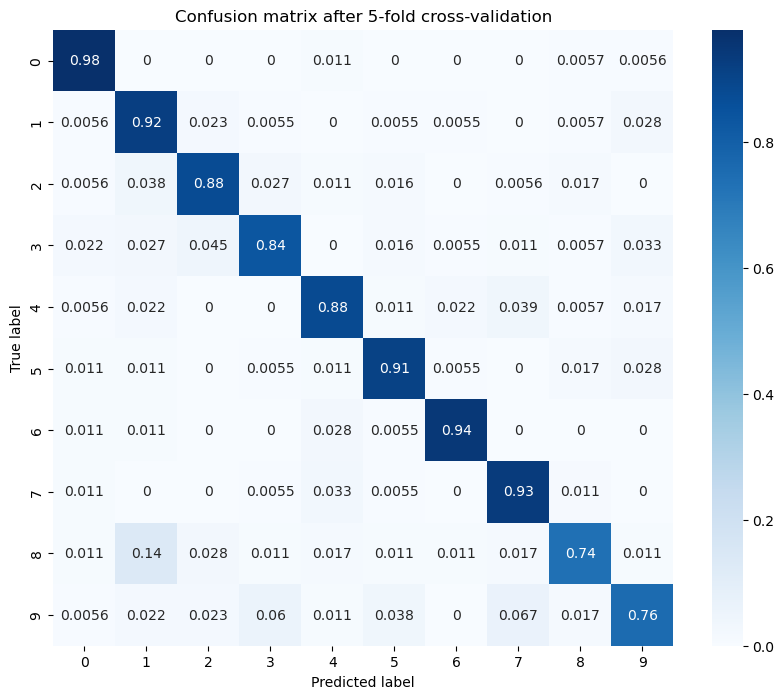

2min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%%timeit -n 1 -r 1

# Train DecisionForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
features = digits.data
labels = digits.target

splitter = KFold(n_splits=5)
classes = list(np.unique(labels))

forest = ClassificationForest(n_trees=10, classes=classes)
confusion_matrix = np.zeros((len(classes), len(classes)))

for train_index, test_index in splitter.split(features):
    forest.train(features[train_index], labels[train_index])

    for sample in test_index:
        label = labels[sample]
        prediction = forest.predict(features[sample])
        confusion_matrix[classes.index(label)][classes.index(prediction)] += 1

print("Accuracy: {:.1%}".format(np.trace(confusion_matrix) / np.sum(confusion_matrix)))

plt.figure(figsize=(10, 8))
seaborn.heatmap(confusion_matrix / np.sum(confusion_matrix, axis=1), annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix after 5-fold cross-validation')
plt.show()

## Discussion of Results
- Identify correctly classified digits: Looking at the diagonal elements (top-left to bottom-right) of the matrix. These values represent the number of instances where the true digit and the predicted digit match. we observe Higher values along the diagonal indicate accurate predictions for each digit.
- Analyze misclassifications: Focusing on the off-diagonal elements of the matrix. These values represent instances where the true digit and the predicted digit do not match. Examining the magnitude of these values, as they indicate the frequency of misclassifications for specific digit pairs, its observed that the 8 has been missclassified as 1 more and even 9 has been misclassified as 3 in some cases and 5 as 9.
- The model correctly predicted the label correct appox 88% of the time.

<div style="color: green">
1.The above code uses %%timeit to measure the execution time for the entire cell. This can be useful for understanding the computational efficiency of the code.<br>
2.The sample code normalizes the confusion matrix, while the above  code uses the raw counts. Normalization could be helpful to compare performance across different classes, especially if the classes are imbalanced.<br>
3.The sample's code calculates and prints out both training and testing errors, whereas the above's code calculates the overall accuracy of the model. It might be beneficial  to also consider calculating and printing these errors.
</div>

# One-against-the-rest classification with RegressionForest

Accuracy: 64.5%


<magic-timeit>:27: RuntimeWarning: divide by zero encountered in divide
<magic-timeit>:27: RuntimeWarning: invalid value encountered in divide


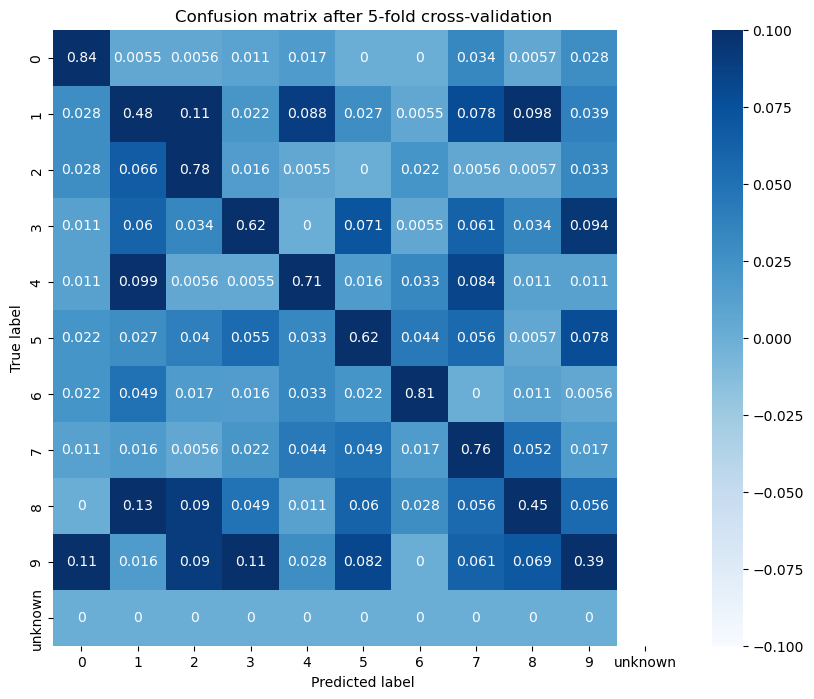

8.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
%%timeit -n 1 -r 1

# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
features = digits.data
labels = digits.target

splitter = KFold(n_splits=5)
classes = list(np.unique(labels))
classes.append("unknown")

forest = RegressionForest()
confusion_matrix = np.zeros((len(classes), len(classes)))

for train_index, test_index in splitter.split(features):
    forest.train(features[train_index], labels[train_index])

    for sample in test_index:
        label = labels[sample]
        prediction = forest.predict(features[sample])
        confusion_matrix[classes.index(label)][classes.index(prediction)] += 1

print("Accuracy: {:.1%}".format(np.trace(confusion_matrix) / np.sum(confusion_matrix)))

plt.figure(figsize=(10, 8))
seaborn.heatmap(confusion_matrix / np.sum(confusion_matrix, axis=1), annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix after 5-fold cross-validation')
plt.show()

## Discussion of Results
Just like with the small-scale comparison, the ClassificationForest clearly outperforms our RegressionForest, especially on the higher numbers - in return, the RegressionForest has a much better performance.

<div style="color: green">
1. The most notable difference is that the above's code does not seem to be implementing one-against-the-rest classifiers, as specified in the task. It appears to be using a single RegressionForest to perform the classification, which is a multi-class approach rather than one-against-the-rest. It's crucial to follow the task instructions and implement ten one-against-the-rest classifiers for the ten digits.<br>
2. The above's code does not show an implementation of balanced bootstrapping between the current target class and the 'rest', as per the task's instructions. Implementing balanced bootstrapping could potentially improve the accuracy of the models. This is an important step to ensure fair representation of each class in each bootstrap sample.<br>
3. The code does not handle the 'unknown' class. The task specifies that the ensemble should return 'unknown' if all scores are negative, i.e., if all classifiers vote for the 'rest'. Adding this functionality can make the code fulfill the task requirements more accurately.<br>
4.The above's code has a time complexity of O(n^2) in the testing phase due to the use of list.index() inside the two for loops. 
</div>